## Coleta de dados

In [381]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

import warnings

In [382]:
def make_capital(x):
    try:
        return x.capitalize()
    except:
        return x    

df = pd.DataFrame()

df_year = {}

warnings.filterwarnings('ignore', category=UserWarning)

for year in range(2019, 2024):
    df_year[year] = pd.read_excel('dados_update.xlsx', str(year))
    
df = pd.concat([df_year[year] for year in range(2019, 2024)])
    
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.dropna(subset='medEnv', inplace=True)
df['medEnv'] = df['medEnv'].apply(lambda x: make_capital(x)).apply(lambda x: x.replace(' ', ''))
df['AvalAdes'] = df['AvalAdes'].replace(np.nan, 'NA')

df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.month)

df['StratIntervPrim'] = df['StratIntervPrim'].apply(lambda x: x.replace('_', ' ').replace('prescrição ', 'prescrição'))
df['ProbRelacPrim'] = df['ProbRelacPrim'].apply(lambda x: x.replace('ção ', 'ção'))
df.Age = np.where(df.Age > 6000, df.Age[df.Age < 6000].mean(), df.Age)

### 1. Quais são os medicamentos mais solicitados, ao longo do tempo?

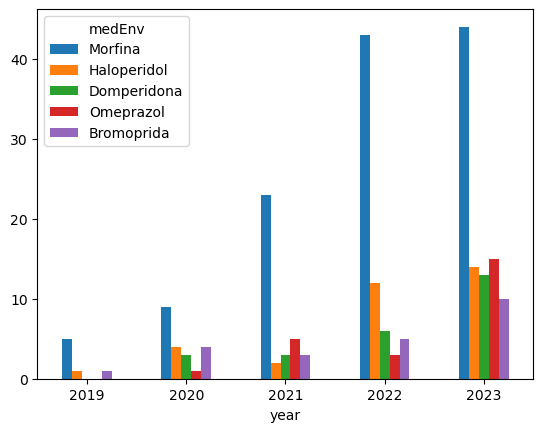

In [498]:
top_5 = df.groupby('medEnv').count().sort_values('Pac', ascending = False).head(5).index.to_list()
df_medenv_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='medEnv')[top_5].plot(use_index=True, kind='bar')#.sort_values(2023, ascending=False)

plt.xticks(rotation=0);

In [499]:
df.pivot_table(index='medEnv', columns='year', values='Pac', aggfunc='count').sort_values(2023, ascending=False).head(11).replace(np.nan, 0)

year,2019,2020,2021,2022,2023
medEnv,,,,,
Morfina,5.0,9.0,23.0,43.0,44.0
Omeprazol,0.0,1.0,5.0,3.0,15.0
Haloperidol,1.0,4.0,2.0,12.0,14.0
Domperidona,0.0,3.0,3.0,6.0,13.0
Dexametasona,0.0,0.0,2.0,7.0,13.0
Quetiapina,0.0,0.0,5.0,3.0,11.0
Bromoprida,1.0,4.0,3.0,5.0,10.0
Ondansetrona,1.0,0.0,2.0,1.0,10.0
Dipirona,2.0,2.0,1.0,5.0,9.0


 ### 2. Qual(is) é(são) as equipes mais acionadas, ao longo do tempo.

<Axes: xlabel='year'>

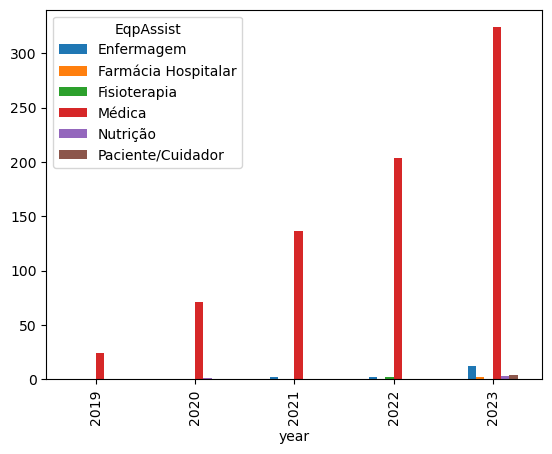

In [500]:
df_eqpassist_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='EqpAssist')#.plot(use_index=True)#.sort_values(2023, ascending=False)
df_eqpassist_per_year.plot(use_index=True, kind='bar')#.sort_values(2023, ascending=False)

In [442]:
freqreldict = {}
for year in range(2019, 2024):

    freqrel = 1/df[df['year'] == year].Pac.count()
    freqreldict[year] = freqrel

df['freqrel'] = df['year'].map(freqreldict)

df.pivot_table(index=['year', 'EqpAssist'], values=['Pac', 'freqrel'], aggfunc={'Pac': 'count', 'freqrel': 'sum'})#.plot(kind='bar', stacked=True)

df_eqp_pivot = df.pivot_table(index='year', values='Pac', aggfunc='count')
df_eqp_pivot['EqpAssist'] = ''
df_eqp_pivot['freqrel'] = 1

df_eqp_pivot = df_eqp_pivot.reset_index().set_index(['year', 'EqpAssist'])
df_final_pivot = pd.concat([df.pivot_table(index=['year', 'EqpAssist'], values=['Pac', 'freqrel'], aggfunc={'Pac': 'count', 'freqrel': 'sum'}), df_eqp_pivot]).sort_values(['year', 'EqpAssist'])

df_final_pivot


Pac   freqrel
year EqpAssist                         
2019                       24  1.000000
     Médica                24  1.000000
2020                       72  1.000000
     Médica                71  0.986111
     Nutrição               1  0.013889
2021                      138  1.000000
     Enfermagem             2  0.014493
     Médica               136  0.985507
2022                      209  1.000000
     Enfermagem             2  0.009569
     Fisioterapia           2  0.009569
     Médica               204  0.976077
2023                      345  1.000000
     Enfermagem            12  0.034783
     Farmácia Hospitalar    2  0.005797
     Médica               324  0.939130
     Nutrição               3  0.008696
     Paciente/Cuidador      4  0.011594

In [441]:
df_final_pivot.to_excel('equipes_por_ano.xlsx')

### 3. Correlação entre problema primário e secundário

In [444]:
freqreldict = {}
for ProbRelacPrim in np.unique(df.ProbRelacPrim.to_list()):

    freqrel = 1/df[df['ProbRelacPrim'] == ProbRelacPrim].Pac.count()
    freqreldict[str(ProbRelacPrim)] = freqrel

freqreldict

df['FreqRel'] = df.ProbRelacPrim.map(freqreldict)

true_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

aval_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], columns='AvalAdes', values='Pac', aggfunc='count')
aval_pivot.replace(np.nan, 0, inplace=True)
aval_pivot['AdesRate'] = (aval_pivot['A'])/(aval_pivot['A'] + aval_pivot['NAJ']+ aval_pivot['NA'])

true_pivot = true_pivot.join(aval_pivot).drop(columns=['A', 'NA', 'NAJ'])#, inplace=True)

sub_pivot = df.pivot_table(index='ProbRelacPrim', values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

sub_aval_pivot = df.pivot_table(index=['ProbRelacPrim'], columns='AvalAdes', values='Pac', aggfunc='count')
sub_aval_pivot.replace(np.nan, 0, inplace=True)
sub_aval_pivot['AdesRate'] = (sub_aval_pivot['A'])/(sub_aval_pivot['A'] + sub_aval_pivot['NAJ']+ sub_aval_pivot['NA'])

sub_pivot = sub_pivot.join(sub_aval_pivot, on=['ProbRelacPrim']).drop(columns=['A', 'NA', 'NAJ'])

sub_pivot['ProbRelacSec'] = ''
sub_pivot.reset_index(inplace=True)
sub_pivot.set_index(['ProbRelacPrim', 'ProbRelacSec'], inplace=True)

final_pivot = pd.concat([true_pivot, sub_pivot]).sort_values(['ProbRelacPrim', 'ProbRelacSec'])
final_pivot.rename(columns={'Pac': 'Frequência Absoluta', 'FreqRel': 'Frequência Relativa', 'AdesRate': 'Taxa de Adesão'}, inplace=True)

final_pivot

Frequência Absoluta  \
ProbRelacPrim ProbRelacSec                                                              
Adesão                                                                             11   
               Automedicação indevida pelo paciente                                 4   
               Descontinuação indevida do medicamento pelo pa...                    1   
               Falta de adesão ao tratamento pelo paciente                          4   
               Problema de acesso à medicação                                       2   
Administração                                                                      41   
               Conservação/preparo inadequado (diluente/estab...                    2   
               Dose/concentração inadequada                                         4   
               Horário/frequência inadequada                                        3   
               Incompatibilidade medicamentosa contraindicada                       5   
               Omissão de doses (subdosagem)                                        6   
               Outros problemas de administração                                    9   
               Via inadequada                                                       9   
              Medicamento inapropriado ou contraindicado                            3   
Dispensação                                                                       122   
               Dose/quantidade incorreta                                            2   
               Falta no estoque                                                   107   
               Forma farmacêutica incorreta                                         2   
               Medicamento incorreto                                                1   
               Outros problemas de dispensação                                      8   
               Outros problemas de prescrição                                       2   
Outros                                                                             10   
               (descrever na coluna "Observações")                                  5   
               Disponibilidade de alternativa medicamentosa m...                    1   
               Prescrito medicamento não-padronizado                                2   
               Reação adversa importante                                            2   
Prescrição                                                                        585   
               Disponibilidade de alternativa medicamentosa m...                    8   
               Dose abaixo das recomendações (subdose)                             48   
               Dose acima das recomendação (sobredose)                             50   
               Duração do tratamento prescrita inadequada                          14   
               Forma farmacêutica ou via de administração pre...                   98   
               Frequência ou horários de administração prescr...                   24   
               Medicamento sem indicação clínica definida                          13   
               Omissão de doses (subdosagem)                                        1   
               Outros problemas de prescrição                                     139   
               Outros problemas de utilização                                       1   
               Possível incompatibilidade medicamentosa contr...                    2   
               Possível interação medicamento-alimento import...                    3   
               Possível interação medicamento-medicamento con...                   20   
               Possível interação medicamento-medicamento grave                     1   
               Prescrito medicamento não-padronizado                               21   
               Via inadequada                                                       1   
              Medicamento em duplicidade na prescrição       

### 4. Correlação entre problema primário e estratégia primária

In [527]:
freqreldict = {}
for ProbRelacPrim in np.unique(df.ProbRelacPrim.to_list()):

    freqrel = 1/df[df['ProbRelacPrim'] == ProbRelacPrim].Pac.count()
    freqreldict[str(ProbRelacPrim)] = freqrel

df['freqrel'] = df['ProbRelacPrim'].map(freqreldict)

prp_pivot = df.pivot_table(index='ProbRelacPrim', 
               values='Pac', aggfunc='count')\
               .sort_values('ProbRelacPrim', 
                            ascending=False)

prp_pivot['StratIntervPrim'] = ''
prp_pivot['freqrel'] = 1


prp_sip_pivot = pd.concat([df.pivot_table(index=['ProbRelacPrim', 'StratIntervPrim'], 
               values=['Pac', 'freqrel'], 
               aggfunc={'Pac': 'count', 'freqrel': 'sum'})\
               .sort_values(['ProbRelacPrim', 'Pac'], 
                            ascending=[True, False]),
prp_pivot.reset_index().set_index(['ProbRelacPrim', 'StratIntervPrim'])
]).sort_values(['ProbRelacPrim', 'freqrel'], 
               ascending=[True, False])

prp_sip_pivot

Pac   freqrel
ProbRelacPrim StratIntervPrim                            
Adesão                                       11  1.000000
              Alteração na prescrição         6  0.545455
              Aconselhamento ao paciente      3  0.272727
              Informação sobre dispensação    2  0.181818
Administração                                41  1.000000
              Alteração na prescrição        24  0.585366
              Orientação de administração     8  0.195122
              Outras intervenções             4  0.097561
              Sinalização informativa         4  0.097561
              Informação sobre dispensação    1  0.024390
Dispensação                                 122  1.000000
              Alteração na prescrição       113  0.926230
              Informação sobre dispensação    6  0.049180
              Outras intervenções             2  0.016393
              Orientação de administração     1  0.008197
Outros                                       10  1.000000
              Sinalização informativa         7  0.700000
              Alteração na prescrição         3  0.300000
Prescrição                                  585  1.000000
              Alteração na prescrição       566  0.967521
              Sinalização informativa        11  0.018803
              Orientação de administração     5  0.008547
              Aconselhamento ao paciente      3  0.005128
Utilização                                   19  1.000000
              Sinalização informativa         8  0.421053
              Alteração na prescrição         5  0.263158
              Aconselhamento ao paciente      3  0.157895
              Orientação de administração     2  0.105263
              Informação sobre dispensação    1  0.052632

In [528]:
prp_sip_pivot.to_excel('estrategia_por_problema.xlsx')

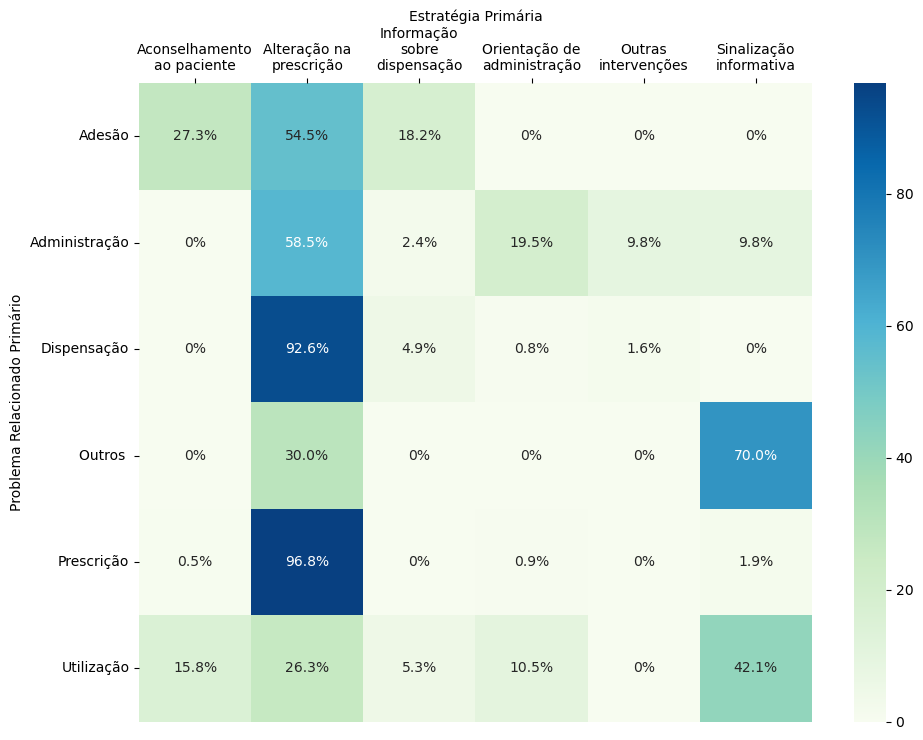

In [593]:
from textwrap import fill

crosstab_prp_sip = pd.crosstab(df.ProbRelacPrim, df.StratIntervPrim, normalize='index') * 100

annot = crosstab_prp_sip.map(lambda x: f'{x:.1f}%').replace('0.0%', '0%');


plt.figure(figsize=(10, 7.5))
ax = sns.heatmap(
    crosstab_prp_sip, 
    cmap='GnBu',
    annot=annot.values, 
    fmt='',
)

# Wrapping y-axis labels without breaking words
wrapped_labels = [fill(label, width=15) for label in crosstab_prp_sip.columns]  # Adjust `width` as needed
plt.yticks(rotation=0, ha='right', fontsize=10)  # Rotate slightly, align right
ax.set_xticklabels(wrapped_labels)
plt.ylabel('Problema Relacionado Primário')
plt.xlabel('Estratégia Primária')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


In [596]:
chi2_test = chi2_contingency(pd.crosstab(df.ProbRelacPrim, df.StratIntervPrim))
print("chi2: ", chi2_test[0], "p-value: ", chi2_test[1])

chi2:  500.9577524597511 p-value:  4.879497510766068e-90


### 5. Correlação entre problema primário e avaliação de adesão

In [599]:
df_adesao_problema = df.pivot_table(index='ProbRelacPrim', values='Pac', aggfunc='count')\
    .join(pd.crosstab(df.ProbRelacPrim, df.AvalAdes, normalize='index')['A']*100)\
    .rename(columns={'Pac': 'Total', 'A': 'Taxa de Adesão'})

df_adesao_problema

,Total,Taxa de Adesão
ProbRelacPrim,,
Adesão,11,81.818182
Administração,41,85.365854
Dispensação,122,97.540984
Outros,10,60.000000
Prescrição,585,90.256410
Utilização,19,63.157895


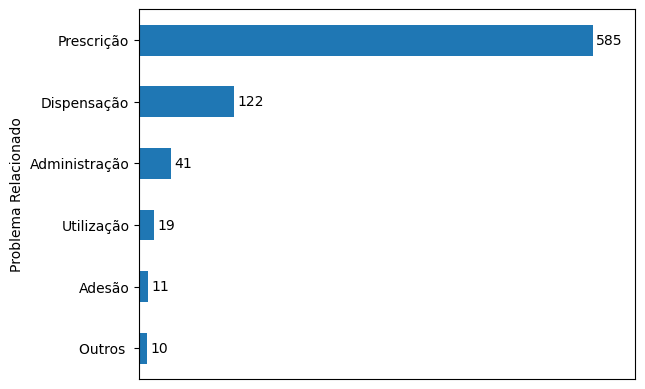

In [502]:
ax = df.groupby('ProbRelacPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh', legend=False);

for bar in ax.patches:
     # Debug: Check bar widths
    ax.annotate(
        f'{round(bar.get_width(), 2)}',
        (bar.get_width() + 5, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    );

plt.xlim(0, 640)
ax.set_xticks([])

plt.ylabel('Problema Relacionado');

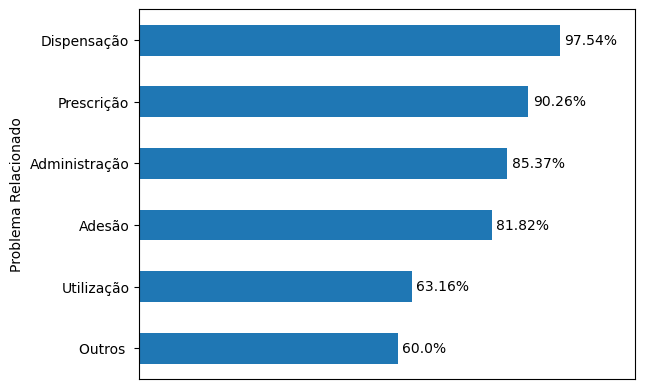

In [306]:
ax = pd.crosstab(df.ProbRelacPrim, df.AvalAdes, normalize='index')[['A']]\
    .sort_values('A', ascending=True)\
    .plot(kind='barh', stacked=True, legend=False)

for bar in ax.patches:
     # Debug: Check bar widths
    ax.annotate(
        f'{round(bar.get_width()*100, 2)}%',
        (bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    );

ax.set_xlim(0, 1.15)

plt.ylabel('Problema Relacionado');
ax.set_xticks([]);

In [604]:
crosstab_prp_aa = pd.crosstab(df.ProbRelacPrim, df.AvalAdes)

print('chi2 = ', chi2_contingency(crosstab_prp_aa)[0])
print('p = ', chi2_contingency(crosstab_prp_aa)[1])

chi2 =  54.168966316906776
p =  4.513006948585101e-08


### 5.2. Correlação entre estratégia primária e avaliação de adesão

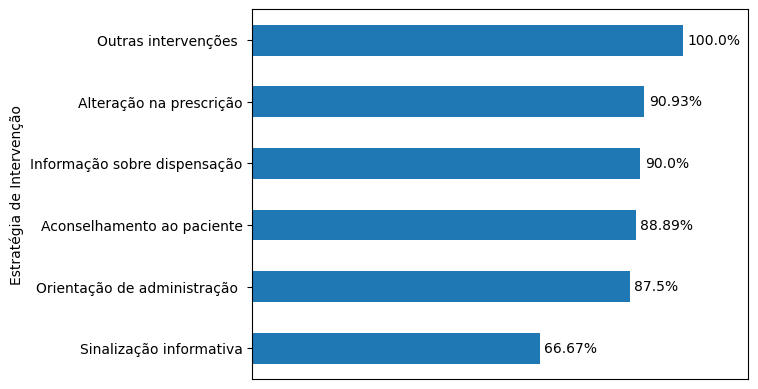

In [605]:
ax = pd.crosstab(df.StratIntervPrim, df.AvalAdes, normalize='index')[['A']]\
    .sort_values('A', ascending=True)\
    .plot(kind='barh', stacked=True, legend=False)

for bar in ax.patches:
     # Debug: Check bar widths
    ax.annotate(
        f'{round(bar.get_width()*100, 2)}%',
        (bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    );

ax.set_xlim(0, 1.15)

plt.ylabel('Estratégia de Intervenção');
ax.set_xticks([]);

In [ ]:
df_adesao_estrategia = df.pivot_table(index='StratIntervPrim', values='Pac', aggfunc='count').join(pd.crosstab(df.StratIntervPrim, df.AvalAdes, normalize='index')).rename(columns={'Pac': 'Total'})
df_adesao_estrategia.to_excel('adesao_a_estrategia.xlsx')

In [603]:
crosstab_sip_aa = pd.crosstab(df.StratIntervPrim, df.AvalAdes)

print('chi2 = ', chi2_contingency(crosstab_sip_aa)[0])
print('p = ', chi2_contingency(crosstab_sip_aa)[1])

chi2 =  35.24972762687364
p =  0.00011318475702245058


### 6. Correlação entre estratégia primária e estratégia secundária

Text(0, 0.5, 'Estratégia de Intervenção')

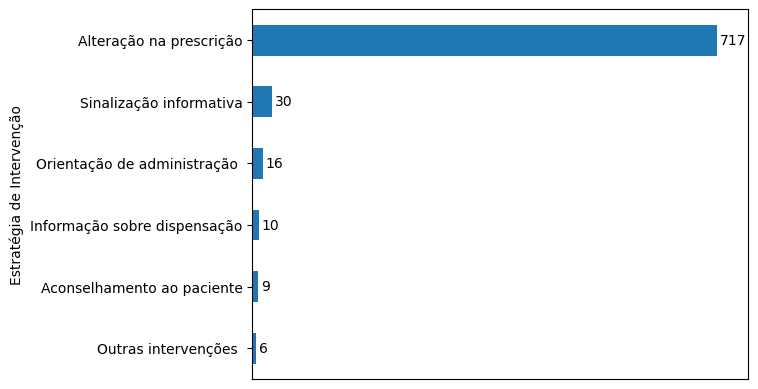

In [606]:
ax = df.groupby('StratIntervPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh', legend=False);

for bar in ax.patches:
     # Debug: Check bar widths
    ax.annotate(
        f'{round(bar.get_width(), 2)}',
        (bar.get_width() + 5, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    );

plt.xlim(0, 765)
ax.set_xticks([])

plt.ylabel('Estratégia de Intervenção')

In [446]:
freqreldict = {}
for StratIntervPrim in np.unique(df.StratIntervPrim.to_list()):

    freqrel = 1/df[df['StratIntervPrim'] == StratIntervPrim].Pac.count()
    freqreldict[str(StratIntervPrim)] = freqrel

freqreldict

df['FreqRel'] = df.StratIntervPrim.map(freqreldict)

true_pivot = df.pivot_table(index=['StratIntervPrim', 'StratIntervSec'], values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

aval_pivot = df.pivot_table(index=['StratIntervPrim', 'StratIntervSec'], columns='AvalAdes', values='Pac', aggfunc='count')
aval_pivot.replace(np.nan, 0, inplace=True)
aval_pivot['AdesRate'] = (aval_pivot['A'])/(aval_pivot['A'] + aval_pivot['NAJ']+ aval_pivot['NA'])

true_pivot = true_pivot.join(aval_pivot).drop(columns=['A', 'NA', 'NAJ'])#, inplace=True)

sub_pivot = df.pivot_table(index='StratIntervPrim', values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

sub_aval_pivot = df.pivot_table(index=['StratIntervPrim'], columns='AvalAdes', values='Pac', aggfunc='count')
sub_aval_pivot.replace(np.nan, 0, inplace=True)
sub_aval_pivot['AdesRate'] = (sub_aval_pivot['A'])/(sub_aval_pivot['A'] + sub_aval_pivot['NAJ']+ sub_aval_pivot['NA'])

sub_pivot = sub_pivot.join(sub_aval_pivot, on=['StratIntervPrim']).drop(columns=['A', 'NA', 'NAJ'])

sub_pivot['StratIntervSec'] = ''
sub_pivot.reset_index(inplace=True)
sub_pivot.set_index(['StratIntervPrim', 'StratIntervSec'], inplace=True)

final_pivot = pd.concat([true_pivot, sub_pivot]).sort_values(['StratIntervPrim', 'StratIntervSec'])
final_pivot.rename(columns={'Pac': 'Frequência Absoluta', 'FreqRel': 'Frequência Relativa', 'AdesRate': 'Taxa de Adesão'}, inplace=True)

final_pivot

Frequência Absoluta  \
StratIntervPrim              StratIntervSec                                                            
Aconselhamento ao paciente                                                                         9   
                             Aconselhamento sobre uso/adesão                                       4   
                             Informação sobre acesso                                               2   
                             Outros aconselhamentos ao paciente/cuidador                           3   
Alteração na prescrição                                                                          717   
                              Outras sinalizações/alertas                                          2   
                             Adição de medicamento                                               109   
                             Ajuste de dose por função renal                                       2   
                             Alteração de diluente                                                 3   
                             Alteração na concentração/diluição                                   17   
                             Alteração na forma farmacêutica / via de admini...                  101   
                             Alteração na posologia/horários de administração                     42   
                             Alteração_na_prescrição >> Aumento de dosagem (...                    1   
                             Aumento de dosagem (clínico)                                         44   
                             Diminuição de dosagem (clínico)                                      47   
                             Informação sobre disponibilidade/logística                            1   
                             Orientação sobre administração/via                                    2   
                             Outras alterações na prescrição                                      82   
                             Substituição de medicamento por questões logíst...                  119   
                             Substituição de medicamento por questões técnic...                   40   
                             Suspensão de medicamento                                            105   
Informação sobre dispensação                                                                      10   
                             Informação sobre disponibilidade/logística                            8   
                             Orientação à Farmácia Hospitalar sobre dispensação                    1   
                             Substituição de medicamento por questões logíst...                    1   
Orientação de administração                                                                       16   
                              Orientação sobre aprazamento/horário de admini...                    5   
                              Orientação sobre dose/posologia                                      1   
                              Orientação sobre manipulação/preparo                                 3   
                              Outras orientações de administração                                  3   
                             Orientação sobre administração/via                                    4   
Outras intervenções                                                                                6   
                             (descrever na coluna "Observações")                                   6   
Sinalização informativa                                                                           30   
                              Alerta de Reação Adversa a Medicamento                               1   
                              Alerta de interação med-med contraindicada                          13   
                              Outras sinalizações/alertas                                         12   
                         

### 7. Distribuição de Idade dos Pacientes

In [131]:
df[['Age']].describe().drop('count')

,Age
mean,68.173028
std,16.458506
min,17.000000
25%,57.000000
50%,68.000000
75%,82.000000
max,103.000000


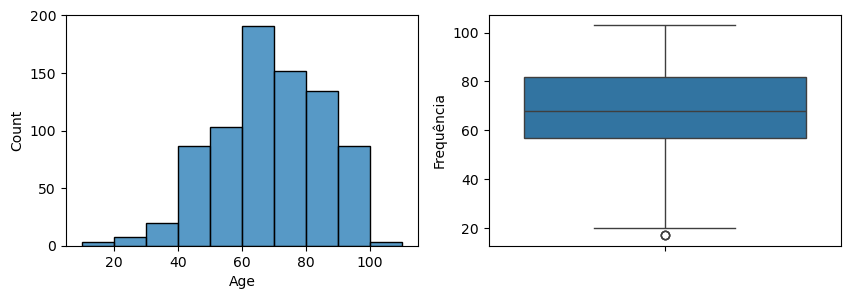

In [455]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(df.Age, bins=10, binwidth=10, binrange=(10, 110), ax=ax[0]);
plt.ylabel('Frequência')

sns.boxplot(df.Age);

### Correlação entre Idade e Medicação

In [134]:
df.pivot_table(index='medEnv', values='Age', aggfunc='mean')

,Age
medEnv,
Abiraterona,91.000000
Acetilcisteína,60.500000
Aguaparainjetáveis,90.000000
Albendazol,82.000000
Alopurinol,78.000000
...,...
Zolpidem,74.333333
Ácidotranexâmico,63.666667
Ácidozoledrônico,78.000000


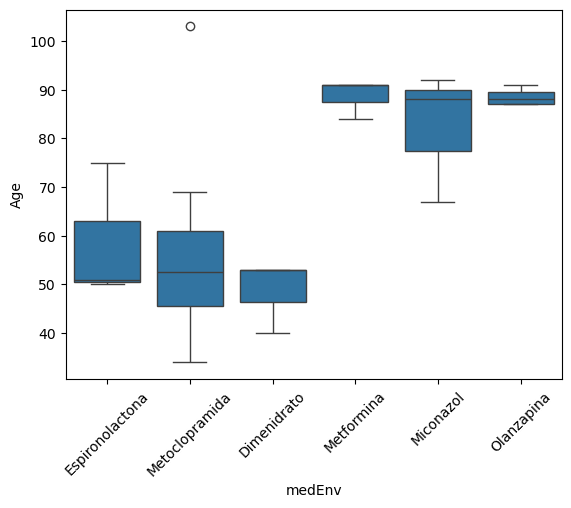

In [465]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_gby_me = df.pivot_table(index='medEnv', values='Age', aggfunc=['median', 'count'])

bot_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age')).head(3).index.to_list()
top_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age'), ascending=False).head(3).index.to_list()

sns.boxplot(data=df[df['medEnv'].isin(bot_5 + top_5)], x='medEnv', y='Age', order=bot_5 + top_5)
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

In [463]:
age_groups = [df[['Age']][df['medEnv'] == group] for group in df['medEnv'].unique() if df['medEnv'][df['medEnv'] == group].count() >= 2]

anova_age_med = stats.f_oneway(*age_groups)
print("F-Statistic:", anova_age_med[0],"\n p-valor: ", anova_age_med[1])

F-Statistic: [2.08526542] 
 p-valor:  [4.55208936e-07]


### Idade e Adesão

In [464]:
df_dropped = df[df.AvalAdes.apply(lambda x: x == x)]

grouped_data = [(df_dropped[df_dropped['AvalAdes'] == group][['Age']]) for group in df_dropped['AvalAdes'].unique()]

#i = 0
#for group in df_dropped['AvalAdes'].unique():
#    print(group, grouped_data[i].mean())

#    i= i+1


anova_age_ades = stats.f_oneway(*grouped_data)
print("F-Statistic:", anova_age_ades[0],"\n p-valor: ", anova_age_ades[1])

F-Statistic: [0.29201347] 
 p-valor:  [0.74683956]


In [ ]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
F_statistic, p_value = stats.f_oneway(*grouped_data)
F_statistic, p_value

In [480]:
bins = range(10, 111, 10) 
labels = [f'{i}-{i+9}' for i in bins[:-1]]

df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Age_group'] = df['Age_group'].cat.rename_categories({'10-19': '-20'})


df_adesao_idade = df.pivot_table(index='Age_group', values='Pac', aggfunc='count', observed=False).join(pd.crosstab(df.Age_group, df.AvalAdes, normalize='index')).rename(columns={'Pac': 'Total'})

df_adesao_idade#.to_excel('adesao_por_idade.xlsx')


,Total,A,NA,NAJ
Age_group,,,,
-20,3,1.000000,0.000000,0.000000
20-29,8,1.000000,0.000000,0.000000
30-39,20,1.000000,0.000000,0.000000
40-49,87,0.908046,0.022989,0.068966
50-59,103,0.864078,0.106796,0.029126
60-69,191,0.858639,0.115183,0.026178
70-79,152,0.927632,0.072368,0.000000
80-89,134,0.925373,0.037313,0.037313
90-99,87,0.896552,0.068966,0.034483


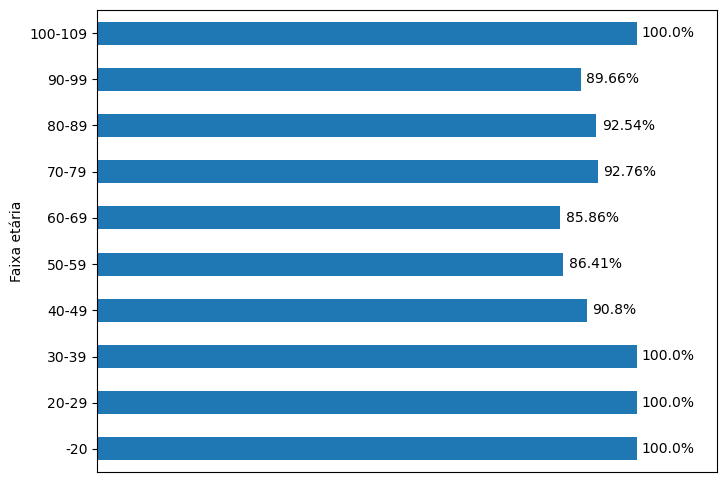

In [481]:
# Criando o gráfico de barras horizontais
ax = df_adesao_idade.plot(kind='barh', y='A', legend=False, figsize=(8, 6))

for bar in ax.patches:
    ax.annotate(
        f'{round(bar.get_width()*100, 2)}%',
        (bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    )

ax.set_xlim(0, 1.15)

plt.ylabel('Faixa etária')
ax.set_xticks([]);

### Idade por Unidade Clínica

In [171]:
df.pivot_table(index='UniClin', values='Age', aggfunc='mean')

,Age
UniClin,
ALA A,64.101836
ALA C,81.075905


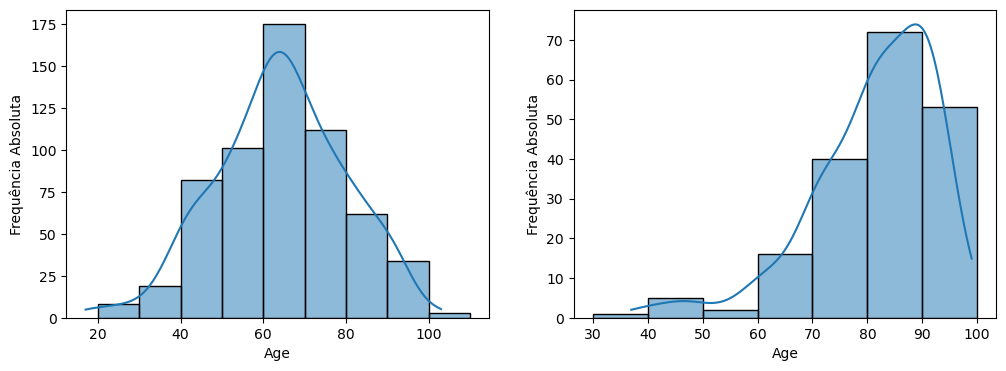

In [254]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df[df['UniClin'] == 'ALA A']['Age'], kde=True, binwidth=10, binrange=(20, 110), ax=ax[0]);
ax[0].set_ylabel('Frequência Absoluta');

sns.histplot(df[df['UniClin'] == 'ALA C']['Age'], kde=True, binwidth=10, binrange=(30, 100));
plt.ylabel('Frequência Absoluta');


### Adesão por Ala

In [482]:
pd.crosstab(df.UniClin, df.ProbRelacPrim, normalize='index').transpose().sort_values('ALA C', ascending=False)*100

UniClin,ALA A,ALA C
ProbRelacPrim,,
Prescrição,73.121870,77.777778
Dispensação,15.692821,14.814815
Administração,5.342237,4.761905
Utilização,2.671119,1.587302
Adesão,1.502504,1.058201
Outros,1.669449,0.000000


In [488]:
df_adesao_ala = df.pivot_table(index='UniClin', values='Pac', aggfunc='count').join(pd.crosstab(df.UniClin, df.AvalAdes, normalize='index')).rename(columns={'Pac': 'Total'})
df_adesao_ala#.to_excel('adesao_por_ala.xlsx')

,Total,A,NA,NAJ
UniClin,,,,
ALA A,599,0.901503,0.075125,0.023372
ALA C,189,0.894180,0.063492,0.042328


In [491]:
crosstab_uc_aa = pd.crosstab(df.UniClin, df.AvalAdes, normalize='index')

In [492]:
chi2_contingency(crosstab_uc_aa)[0], chi2_contingency(crosstab_uc_aa)[1]

(0.006475231119097114, 0.9967676198660846)

### IFs Aceitas


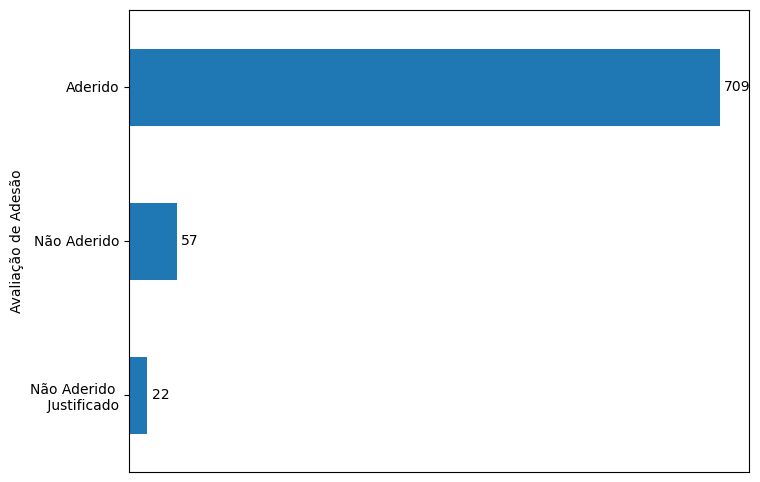

In [493]:
#

ax = df.pivot_table(values='Pac', index='AvalAdes', aggfunc='count').sort_values('Pac').plot(kind='barh', figsize=(8, 6), legend=False)

for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_width())}', 
        (bar.get_width()+ 5, bar.get_y() + bar.get_height() / 2),
        ha='left', va='center', fontsize=10
    )

ax.set_xticks([])


ax.set_xticks([])
plt.ylabel('Avaliação de Adesão')

plt.yticks(
    range(len(ax.get_yticklabels())),  # Numeric positions
    ['Aderido', 'Não Aderido', 'Não Aderido \n Justificado'][::-1]);


### Gráfico de Adesão

In [495]:
df_aval_year = df.pivot_table(index='year', columns='AvalAdes', values='Pac', aggfunc='count')
df_aval_year.replace(np.nan, 0, inplace=True)

df_aval_year['Total'] = df_aval_year['A'] + df_aval_year['NA'] + df_aval_year['NAJ']
df_aval_year['AdesRate'] = df_aval_year['A']/df_aval_year['Total']*100

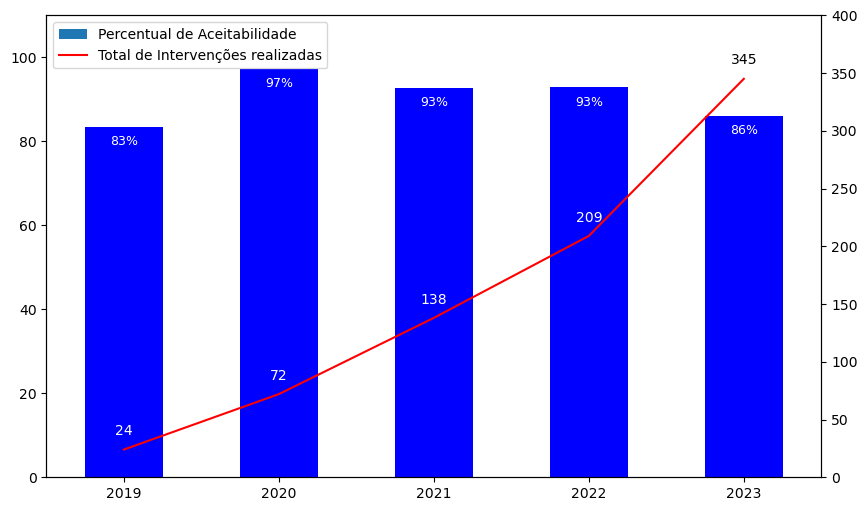

In [497]:


fig, ax1 = plt.subplots(figsize=(10, 6))

df_aval_year.plot(y='AdesRate', kind='bar', legend=False, ax=ax1, color='blue')

plt.xticks(rotation=0)
plt.xlabel('')

for i, value in enumerate(df_aval_year['AdesRate']):
    ax1.text(i, value - 5, f'{str(round(value))}%', ha='center', va='bottom', fontsize=9, color='white')

ax2 = ax1.twinx()

df_aval_year.reset_index().plot(y='Total', kind='line', color='red', ax=ax2, legend=False)

for i, value in enumerate(df_aval_year.reset_index()['Total']):
    ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='white')

ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='black')

ax1.set_ylim(0, 110)
ax2.set_ylim(0, 400)

ax1.set_xlim(-0.5, len(df_aval_year) - 0.5)

bar_legend = ax1.bar([], [], color='blue', label='Percentual de Aceitabilidade')
line_legend, = ax2.plot([], [], color='red', label='Total de Intervenções realizadas')

ax1.legend(handles=[bar_legend, line_legend], loc='upper left', fontsize=10);